Para Set1:
SIS without total space in lg2:  -354.363609774930
SIS without total space in lg2 sqrt:  -177.181804887465
SIS with total space in lg2:  156.636390225070
SIS with total space in lg2 sqrt:  78.3181951125352


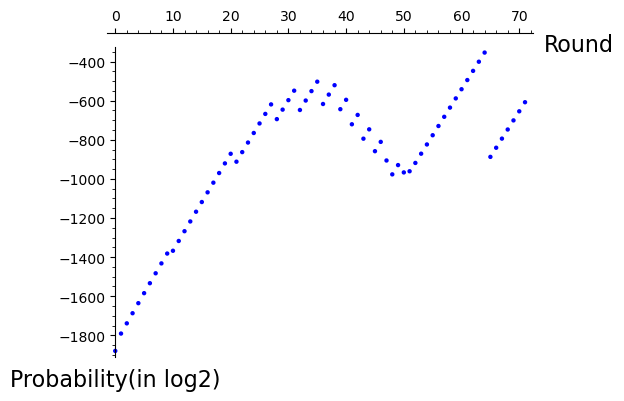

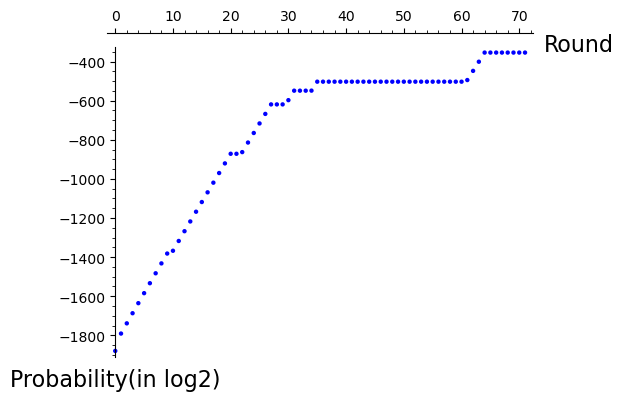

Para Set2:
Para Set3:


In [6]:
"""
adapted from Kyber estimate code
"""


def binomial(x, y):
    """ Binomial coefficient
    :param x: (integer)
    :param y: (integer)
    :returns: y choose x
    """
    try:
        binom = factorial(x) // factorial(y) // factorial(x - y)
    except ValueError:
        binom = 0
    return binom


def centered_binomial_pdf(k, x):
    """ Probability density function of the centered binomial law of param k at x
    :param k: (integer)
    :param x: (integer)
    :returns: p_k(x)
    """
    return binomial(2 * k, x + k) / 2. ** (2 * k)


def build_centered_binomial_law(k):
    """ Construct the binomial law as a dictionnary
    :param k: (integer)
    :param x: (integer)
    :returns: A dictionnary {x:p_k(x) for x in {-k..k}}
    """
    D = {}
    for i in range(-k, k + 1):
        D[i] = centered_binomial_pdf(k, i)
    return D


def law_convolution(A, B):
    """ Construct the convolution of two laws (sum of independent variables from two input laws)
    :param A: first input law (dictionnary)
    :param B: second input law (dictionnary)
    """

    C = {}
    for a in A:
        for b in B:
            c = a + b
            C[c] = C.get(c, 0) + A[a] * B[b]
    return C


def law_product(A, B):
    """ Construct the law of the product of independent variables from two input laws
    :param A: first input law (dictionnary)
    :param B: second input law (dictionnary)
    """
    C = {}
    for a in A:
        for b in B:
            c = a * b
            C[c] = C.get(c, 0) + A[a] * B[b]
    return C


def iter_law_convolution(A, i):
    """ compute the -ith forld convolution of a distribution (using double-and-add)
    :param A: first input law (dictionnary)
    :param i: (integer)
    """
    D = {0: 1.0}
    i_bin = bin(i)[2:]  # binary representation of n
    count = 0
    for ch in i_bin:
        count += 1
        D = law_convolution(D, D)
        D = clean_dist(D)
        # print("count: ", count)
        if ch == '1':
            D = law_convolution(D, A)
            D = clean_dist(D)
    return D


def clean_dist(A):
    """ Clean a distribution to accelerate further computation (drop element of the support with proba less than 2^-300)
    :param A: input law (dictionnary)
    """
    B = {}
    for (x, y) in A.items():
        if y > 2 ** (-1000):
            B[x] = y
    return B


def build_error_distribtion(e):
    D = {}
    for i in range(-e, e + 1):
        D[i] = 1 / (2 * e + 1)
    return D


"""
SIS part function
"""


def cardinality_s(alpha, n):  # |S_alpha|
    return (2 * alpha + 1) ** n  # n is the number of coefficient. eg. f0 ~ f255


def calculate_volume(radius, n):  # V_n(R)
    return (((math.pi / 2) ** int(n / 2)) / n.multifactorial(2)) * ((2 * radius) ** n)


def SIS_tau_partial(q, l, k, alpha1, alpha2, n, wi_inf, wi):
    S_alpha1_wi = cardinality_s(alpha1 + wi_inf, n)
    S_alpha2_wi = cardinality_s(alpha2 + wi_inf, n)
    up = (S_alpha1_wi ** l) * (S_alpha2_wi ** k)
    down = (wi ** (l + k))
    return up / down


"""
display convinience
"""


def lg2_convert(number):
    return RR(log(number, 2))


# CBD part
def CBD_part(para_set):
    # paras
    n, k, q, eta1, eta2, du, dv, total_space = para_set[0], para_set[1], para_set[2], para_set[3], para_set[4], \
                                               para_set[5], para_set[6], para_set[7]

    # cbd for single coefficient in delta r & e1
    dict_r = build_centered_binomial_law(eta1)
    dict_e1 = build_centered_binomial_law(eta2)
    delta_r_single = law_convolution(dict_r, dict_r)
    delta_e1_single = law_convolution(dict_e1, dict_e1)

    # prob delta r
    prob_delta_r = delta_r_single[0] ** (n * k)

    # prob delta e1 in [-floor(eu), floor(eu)]
    eu = int(q // (2 ** du))
    prob_e1_single = 0
    for eu_term in range(-1 * eu, eu + 1):
        # print("eu_term: ", eu_term)
        # print("delta_e1_single[eu_term]: ", delta_e1_single[eu_term])
        prob_e1_single += delta_e1_single[eu_term]
    prob_delta_e1 = prob_e1_single ** (n * k)

    # produce delta r + delta e1 in CBD
    prob_CBD = prob_delta_r * prob_delta_e1

    print("prob_CBD without total space in lg2: ", lg2_convert(prob_CBD))
    print("prob_CBD without total space in lg2 sqrt: ", lg2_convert(prob_CBD) / 2)
    print("prob_CBD with total space in lg2: ", lg2_convert(prob_CBD * total_space))
    print("prob_CBD with total space in lg2 sqrt: ", lg2_convert(prob_CBD * total_space) / 2)
    return prob_CBD


# SIS prob

def SIS_s(q, l, k, alpha1, alpha2, n):
    S_alpha1 = cardinality_s(alpha1, n)
    S_alpha2 = cardinality_s(alpha2, n)
    up = (S_alpha1 ** l) * (S_alpha2 ** k)
    down = q ** (n * k)
    return up / down


def SIS_tau(q, l, k, alpha1, alpha2, n, d):
    e = int(d * log(alpha1 * sqrt(n), q))
    result = 0
    single_list = []
    result_list = []

    for i in range(1, e + 1):
        # fix part
        t = int(q ** (i / d) / 2)
        fix_part = binomial(d, i) / (q ** (n * k * (1 - i / d)))

        # wi comparision
        if i == 1:
            W_i_inf = 1  # ||W||_inf
            W_i_cardinality = 2 * n  # |W1| = 2n
            partial = SIS_tau_partial(q, l, k, alpha1, alpha2, n, W_i_inf, W_i_cardinality)
        elif t < sqrt(n):
            W_i_inf = 1
            W_i_cardinality = 0
            for j in range(t ** 2 + 1):
                W_i_cardinality += binomial(n, j) * (2 ** j)
            partial = SIS_tau_partial(q, l, k, alpha1, alpha2, n, W_i_inf, W_i_cardinality)
        else:
            # comparision

            set1_W_i_inf = t
            radius = q ** (i / d) / 2 - sqrt(n)
            set1_W_i_cardinality = RR(calculate_volume(radius, n))

            set2_W_i_inf = int(t / sqrt(n))
            set2_W_i_cardinality = (2 * set2_W_i_inf + 1) ** n

            compare_1 = SIS_tau_partial(q, l, k, alpha1, alpha2, n, set1_W_i_inf, set1_W_i_cardinality)
            compare_2 = SIS_tau_partial(q, l, k, alpha1, alpha2, n, set2_W_i_inf, set2_W_i_cardinality)
            partial = min(compare_1, compare_2)

        single_round = fix_part * partial
        single_list.append(lg2_convert(single_round))
        result += single_round
        result_list.append(lg2_convert(result))
        
        result_plot = []
        result_plot.append(result)
        result_plot.append(single_list)
        result_plot.append(result_list)
    
    return result_plot
    
    
    #return result


def SIS_part(para_set):
    # paras
    n, k, q, eta1, eta2, du, dv, total_space = para_set[0], para_set[1], para_set[2], para_set[3], para_set[4], \
                                               para_set[5], para_set[6], para_set[7]
    d = 128
    eu = int(q // (2 ** du))
    alpha1 = 2 * eta1
    alpha2 = 2 * eta2 + eu
    s_part = SIS_s(q, k, k, alpha1, alpha2, n)
    tau_part = SIS_tau(q, k, k, alpha1, alpha2, n, d)[0]
    result = s_part + tau_part

    # times delta r != 0
    dict_r = build_centered_binomial_law(eta1)
    delta_r_single = law_convolution(dict_r, dict_r)
    prob_delta_r = delta_r_single[0] ** (n * k)
    prob_r_non_zero = 1 - prob_delta_r

    result = prob_r_non_zero * result
    cumulative_result = total_space * result
    print("SIS without total space in lg2: ", lg2_convert(result))
    print("SIS without total space in lg2 sqrt: ", lg2_convert(result) / 2)
    print("SIS with total space in lg2: ", lg2_convert(cumulative_result))
    print("SIS with total space in lg2 sqrt: ", lg2_convert(cumulative_result) / 2)
    # print("---")
    
    single_list = SIS_tau(q, k, k, alpha1, alpha2, n, d)[1]
    result_list = SIS_tau(q, k, k, alpha1, alpha2, n, d)[2]
    plot_single = list_plot([single_list[i] for i in range(len(single_list))], title="", axes_labels=[r'Round', r'Probability(in log2)'])
    plot_result = list_plot([result_list[i] for i in range(len(result_list))], title="", axes_labels=[r'Round', r'Probability(in log2)'])
    # axes_labels=[r'Round', r'Probability(in log2)']
    plot_single.show()
    plot_result.show()

    return result


# v part

def v_part(para_set):
    # paras
    n, k, q, eta1, eta2, du, dv, total_space = para_set[0], para_set[1], para_set[2], para_set[3], para_set[4], \
                                               para_set[5], para_set[6], para_set[7]
    eu = int(q // (2 ** du))
    ev = int(q // (2 ** dv))
    round_half_q = round(q / 2)

    # distribution
    s_distr = build_centered_binomial_law(eta1)
    e_distr = s_distr
    r_distr = s_distr
    e1_distr = build_centered_binomial_law(eta2)
    e2_distr = e1_distr
    delta_e1_distr = law_convolution(e1_distr, e1_distr)
    delta_e2_distr = delta_e1_distr
    delta_r_distr = law_convolution(r_distr, r_distr)

    # law product & iteration

    e_delta_r = law_product(e_distr, delta_r_distr)
    e_delta_r_nk = iter_law_convolution(e_delta_r, n * k)

    s_delta_e1 = law_product(s_distr, delta_e1_distr)
    s_delta_e1_nk = iter_law_convolution(s_delta_e1, n * k)

    combine_1 = law_convolution(e_delta_r_nk, s_delta_e1_nk)
    print("combine 1 finished.")
    combine_2 = law_convolution(combine_1, delta_e2_distr)
    print("combine 2 finished.")

    total_prob = 0

    for eu_add in range((-1) * eu, eu + 1):  # iterate eu from -floor(eu) to floor(eu)
        eu_distr = {eu_add: 1}
        s_eu = law_product(s_distr, eu_distr)
        #  print("eu: ", eu_add)
        combine_3 = law_convolution(combine_2, s_eu)
        # print("combine 3 finished.")
        # print("prob_0: ", RR(combine_3[0]))

        for ev_add in range((-1) * ev, ev + 1):  # iterate ev from -floor(ev) to floor(ev)
            x = round_half_q + ev_add
            y = (-1) * round_half_q + ev_add
            total_prob += combine_3[x] + combine_3[y]
        # print("total_prob_no_0 in lg2: ", lg2_convert(total_prob_no_0))
        # print("total_prob_0 in lg2: ", lg2_convert(total_prob_0))

    total_prob = 256 * total_prob
    
    print("total v in lg 2 without msg: ", lg2_convert(total_prob))

    return total_prob


# total injectivity

def total_injectivity(para_set):
    CBD_prob = CBD_part(para_set)
    SIS_prob = SIS_part(para_set)
    v_prob = v_part(para_set)
    total_prob = (CBD_prob + SIS_prob) * v_prob  # Pr[v=0|u=0] * Pr[u=0] = Pr[v=0 and u=0]
    print("total_prob in lg2 without message space: ", lg2_convert(total_prob))
    print("total_prob in lg2 sqrt without message space: ", lg2_convert(total_prob) / 2)

    total_space = para_set[7]
    print("total_prob in lg2 with message space: ", lg2_convert(total_prob * total_space))
    print("total_prob in lg2 sqrt with message space: ", lg2_convert(total_prob * total_space) / 2)


# parameter sets

# set = n, k, q, eta1, eta2, du, dv, total message space

total_space = 2 ** 511  # binomial (2**256,2)
set1 = [256, 2, 3329, 3, 2, 10, 4, total_space]
set2 = [256, 3, 3329, 2, 2, 10, 4, total_space]
set3 = [256, 4, 3329, 2, 2, 11, 5, total_space]

print("Para Set1:")
SIS_part(set1)
print("Para Set2:")
SIS_part(set2)
print("Para Set3:")
SIS_part(set3)